In [1]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
from mylibrary import count_pixels
import task1
%matplotlib inline

## Edge detection

In [2]:
# sober for edge detection
VERTICAL_SOBEL_3BY3 = np.array([[-1,2,-1],
                          [-1,2,-1],
                          [-1,2,-1]])

HORIZONTAL_SOBEL_3BY3 = np.array([[-1,-1,-1],
                         [2,2,2],
                         [-1,-1,-1]])
POS45_SOBEL_3BY3 = np.array([[-1,-1,2],
                         [-1,2,-1],
                         [2,-1,-1]])
NEG45_SOBEL_3BY3 = np.array([[2,-1,-1],
                         [-1,2,-1],
                         [-1,-1,2]])

In [3]:
def texture_filtering(img_gray, kernel):
    """
    Purpose:
        use to filter the gray image given the kernel
    Input:
        img_gray: 
            an two dimension ndarray matrix, dtype:usually is uint8 representint the gray image.
        kernel: 
            a two dimension ndarray matrix
    Output:
        The filtered image without padding around.
    """
    row_pad = math.floor(kernel.shape[0] / 2)
    col_pad = math.floor(kernel.shape[1] / 2)
    
    res_img = np.zeros(img_gray.shape)
    check_img = np.pad(img_gray, ((row_pad,row_pad),(col_pad, col_pad)), 'constant')
    flipped_kernel = np.flip(kernel)
    
    for i in range(row_pad, check_img.shape[0] - row_pad):
        for j in range(col_pad, check_img.shape[1] - col_pad):
            patch = check_img[i-row_pad:i+row_pad+1, j-col_pad:j+col_pad+1]
            res_img[i-row_pad, j-col_pad] = np.sum(patch * flipped_kernel)
    return res_img

In [4]:
def eliminate_zero(img, method=1):
    """
    Purpose:
        two ways to eliminate the negative value or the value out of 255.
    Input:
        img: two dimension matrix
            the raw image. dtype usually is float64 with pixel < 0 or pixel > 255
        method: int
            default is 1 which directs to first method
            the 2 will direct to the second method.
    Output:
        a matrix dtype range zero to one. 
    """
    if method == 1:
        min_ = np.min(img)
        max_ = np.max(img)
        return (img - min_) / (max_ - min_)
    elif method == 2:
        abs_img = np.abs(img)
        return abs_img / np.max(abs_img)
    else :
        print("method is 1 or 2")

In [5]:
def combine_edge(hori,vert,pos45,neg45,T):
    """
    Purpose:
        to combine edges in four direction. 
        Mark result image 1 in given loc if any of these four edge images pixels absolute value
        greater than T in that loc.
    Output:
        res_img: binary img, value type np.uint8
    """
    hori = np.abs(hori)
    vert = np.abs(vert)
    pos45 = np.abs(pos45)
    neg45 = np.abs(neg45)
    res_img = np.zeros(hori.shape).astype(np.uint8)
    for i in range(hori.shape[0]):
        for j in range(hori.shape[1]):
            if hori[i,j] > T or vert[i,j] > T or pos45[i,j] > T or neg45[i,j] > T :
                res_img[i,j] = 1
    return res_img

In [6]:
def ignore_border(img_gray):
    """
    Purpose:
        ignore the img bodre by setting value as 0.
        notice: Affect original img.
    Output:
        the pointer point to original image.
    """
    img_gray[0] = 0
    img_gray[-1] = 0
    for row in img_gray:
        row[0] = 0
        row[-1] = 0
    return img_gray

In [7]:
def pick_by_count(lines, T):
    """
    Purpose:
        filter the lines which number of (rho, radian) greater than threshold T.
    Input:
        lines: a matrix, col_1: rho, col_2: radian, col_2: number of (rho, radian) tuple. It can be got by res_dic.
    Output:
        matrix, numpy array, each row represent a selected line. 
        
    """
    res = []
    for line in lines:
        if line[2] > T:
            res.append(line)  
    return np.asarray(res)

In [8]:
def pick_by_theta(lines, theta, gap):
    """
    Purpose:
        filter the lines by theta,
    Input:
        lines: a matrix, col_1: rho, col_2: radian, col_2: number of (rho, radian) tuple.
        theta: real, is a radian, will compared radians from col_2
        gap: the maximum difference between two theta.
    Output:
        matrix, numpy array, each row represent a selected line. 
    """
    res = []
    for line in lines:
        if abs(line[1] - theta) < gap:
            res.append(line)  
    return np.asarray(res)

In [9]:
def hough(edge_img):
    """
    Purpose:
        Main function of hough transform.
        Notice: Here I use the rho = x * sin(theta) + y * cos(theta). It is different from the hough equation.
        I do this to meet the convention of opencv so that to use opencv library easily later.
    Input:
        edge_img: binary image, the boundary image after edge detection.
    Output:
        res_dic: a dictionary, key is a tuple (rho, radian), value is the number of its key.
    """
    m, n = edge_img.shape
    res_dic = {}
    for i in range(m):
        for j in range(n):
            if edge_img[i,j] == 1:
                for degree in range(0,180):
                    radian = np.radians(degree)
                    rho = int(i * np.sin(radian) + j * np.cos(radian))
                    if ((rho, radian)) not in res_dic:
                        res_dic[(rho, radian)] = 0
                    res_dic[(rho, radian)] += 1
    return res_dic

In [10]:
def draw_lines(img, lines, loc="../task3_img/", name = "hough_res.jpg"):
    """
    Purpose: 
        draw lines in image
        not affect original imgage.
    """
    img = img.copy()
    for line in lines:
        rho = line[0]
        theta = line[1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
    cv2.imwrite(loc+name, img) 

In [11]:
def circle_hough(edge_img):
    res_dic = {}
    for x in range(edge_img.shape[0]):
        for y in range(edge_img.shape[1]):
            if edge_img[x,y] == 1:
                for r in range(18,28):
                    for t in range(0,360):
                        a = x - r * np.cos(t * np.pi / 180)
                        b = y - r * np.sin(t * np.pi / 180)
                        if (a,b,r) not in res_dic:
                            res_dic[(a,b,r)] = 0
                        res_dic[(a,b,r)] += 1
    return res_dic       

In [12]:
def draw_circles(img, circles, loc="../task3_img/", name="coin.jpg" ):
    img = img.copy()
    for cir in circles:
        cv2.circle(img,(cir[1], cir[0]), cir[2], (0,255,0), 1)
    cv2.imwrite(loc+name, img)

In [13]:
if __name__ == "__main__":
    img = cv2.imread('../task3_img/hough.jpg')
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    print("Start to do edge detection")
    ## get edges from four directions
    vertical = texture_filtering(img_gray, VERTICAL_SOBEL_3BY3)
    horizontal = texture_filtering(img_gray, HORIZONTAL_SOBEL_3BY3)
    pos45 = texture_filtering(img_gray, POS45_SOBEL_3BY3)
    neg45 = texture_filtering(img_gray, NEG45_SOBEL_3BY3)
    
    ## Find threshold through observation
    # vertical
    pixel_stat = count_pixels(np.abs(vertical))
    stat_list = np.asarray([[key,val] for key,val in pixel_stat.items() if key >100]).T
    plt.bar(stat_list[0],stat_list[1],align='center') # A bar chart
    plt.title("pixel numbers count (vert edge, value > 100)")
    plt.xlabel('pixel value')
    plt.ylabel('number')
    plt.savefig("../task3_img/vert_hist")
    plt.close()
    
    #horizontal
    pixel_stat = count_pixels(np.abs(horizontal))
    stat_list = np.asarray([[key,val] for key,val in pixel_stat.items() if key >100]).T
    plt.bar(stat_list[0],stat_list[1],align='center') # A bar chart
    plt.title("pixel numbers count (hori edge, value > 100)")
    plt.xlabel('pixel value')
    plt.ylabel('number')
    plt.savefig("../task3_img/hori_hist")
    plt.close()
    
    #pos45
    pixel_stat = count_pixels(np.abs(pos45))
    stat_list = np.asarray([[key,val] for key,val in pixel_stat.items() if key >100]).T
    plt.bar(stat_list[0],stat_list[1],align='center') # A bar chart
    plt.title("pixel numbers count (pos45 edge, value > 100)")
    plt.xlabel('pixel value')
    plt.ylabel('number')
    plt.savefig("../task3_img/pos45_hist")
    plt.close()
    
    #neg45
    pixel_stat = count_pixels(np.abs(neg45))
    stat_list = np.asarray([[key,val] for key,val in pixel_stat.items() if key >100]).T
    plt.bar(stat_list[0],stat_list[1],align='center') # A bar chart
    plt.title("pixel numbers count (neg45, value > 100)")
    plt.xlabel('pixel value')
    plt.ylabel('number')
    plt.savefig("../task3_img/neg45_hist")
    plt.close()
    
    ## Combined edges using threshold
    T = 50
    combined = combine_edge(horizontal,vertical,pos45,neg45,T)
    combined = ignore_border(combined)
    cv2.imwrite("../task3_img/combined.jpg", (combined*255).astype(np.uint8))
    
    ## preprocess binary image
    print("Start to preprocess binary image")
    #denoise
    struc_elem = np.ones((3,3)).astype(np.uint8)
    denoised = task1.denoising(method=2)(combined, struc_elem)
    cv2.imwrite("../task3_img/denoised.jpg", (denoised*255).astype(np.uint8))
    #closing
    struc_elem = np.ones((7,7)).astype(np.uint8)
    closed = task1.closing(denoised, struc_elem)
    cv2.imwrite("../task3_img/closed.jpg", (closed*255).astype(np.uint8))
    #extract boundary
    boundary = task1.boundary(closed)
    cv2.imwrite("../task3_img/boundary.jpg", (boundary*255).astype(np.uint8))
    
    ## Start using hough algorithms
    print("Start using hough algorithms")
    hres = hough(boundary)
    lines = np.asarray([[key[0], key[1], val] for key, val in hres.items()])
    #filter by theta and count
    #red lines
    T = 160
    theta_gap = 0.2
    theta_red = 3.1
    lines_red = pick_by_theta(lines, theta_red, theta_gap)
    res_red = pick_by_count(lines_red, T)
    draw_lines(img, res_red, loc="../task3_img/", name = "red_line.jpg")

    #blue lines
    T = 140
    theta_gap = 0.2
    theta_blue = 2.5
    lines_blue = pick_by_theta(lines, theta_blue, theta_gap)
    res_blue = pick_by_count(lines_blue, T)
    draw_lines(img, res_blue, loc="../task3_img/", name = "blue_lines.jpg")
    
    #Bonus Circle hough
    print("start hough circle")
    chres = circle_hough(boundary)
    circles = [item for item in chres.items() if chres[item[0]] >= 4]
    circles = np.asarray([[x[0][0], x[0][1], x[0][2], x[1]] for x in circles]).astype(int)
    draw_circles(img, circles)
    #Bonus using Canny edge detection
#     img = cv2.imread('../task3_img/hough.jpg')
#     gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     edges = cv2.Canny(gray,50,150,apertureSize = 3)
#     chres = circle_hough(edges)
#     circles = [item for item in chres.items() if chres[item[0]] >= 4]
#     circles = np.asarray([[x[0][0], x[0][1], x[0][2], x[1]] for x in circles]).astype(int)
#     draw_circles(img, circles, name="coin_edge.jpg")
    
    
    

Start to do edge detection
Start to preprocess binary image
Start using hough algorithms
start hough circle


In [37]:
img = cv2.imread('../task3_img/hough.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)
cv2.imwrite('../task3_img/cannyedge.jpg', edges) 
edges = (edges/255).astype(np.uint)
struc_elem = np.ones((7,7)).astype(np.uint8)
closed = task1.closing(edges, struc_elem)
boundary3 = task1.boundary(closed)
cv2.imwrite("../task3_img/boundary3.jpg", (boundary3*255).astype(np.uint8))

True

In [38]:
edges

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint64)

In [ ]:
chres = circle_hough(edges)

In [26]:
len(chres)

76927137

In [ ]:
1

In [25]:
max(chres)

(503.0, 0.9999999999999967, 27)

In [ ]:
circles = [item for item in chres.items() if chres[item[0]] >= 4]

In [36]:
circles

[((45.0, 268.0, 18), 4),
 ((48.0, 269.0, 19), 4),
 ((48.0, 271.0, 19), 4),
 ((48.0, 275.0, 19), 4),
 ((47.0, 276.0, 18), 4),
 ((55.0, 373.0, 19), 4),
 ((55.0, 376.0, 19), 4),
 ((56.0, 373.0, 18), 4),
 ((56.0, 376.0, 18), 4),
 ((67.0, 541.0, 25), 4),
 ((65.0, 543.0, 20), 4),
 ((69.0, 541.0, 23), 4),
 ((69.0, 544.0, 22), 4),
 ((72.0, 542.0, 24), 4),
 ((68.0, 148.0, 19), 4),
 ((68.0, 543.0, 18), 4),
 ((73.0, 381.0, 20), 4),
 ((74.0, 378.0, 20), 4),
 ((83.0, 516.0, 18), 4),
 ((84.0, 125.0, 18), 4),
 ((89.0, 131.0, 20), 4),
 ((90.0, 130.0, 18), 4),
 ((100.0, 500.0, 27), 4),
 ((127.0, 588.0, 22), 4),
 ((129.0, 589.0, 23), 4),
 ((130.0, 587.0, 21), 4),
 ((131.0, 587.0, 21), 4),
 ((132.0, 591.0, 22), 4),
 ((132.0, 610.0, 19), 4),
 ((136.0, 603.0, 22), 4),
 ((135.0, 602.0, 18), 4),
 ((135.0, 611.0, 18), 4),
 ((144.0, 405.0, 25), 4),
 ((137.0, 599.0, 18), 4),
 ((148.0, 407.0, 26), 4),
 ((149.0, 407.0, 26), 4),
 ((156.0, 69.0, 18), 4),
 ((159.0, 70.0, 21), 4),
 ((157.0, 63.0, 18), 4),
 ((159.0, 7

In [ ]:
circles = np.asarray([[x[0][0], x[0][1], x[0][2], x[1]] for x in circles]).astype(int)

In [ ]:
draw_circles(img, circles, name="coin_edge.jpg")

In [13]:
struc_elem = np.ones((5,5)).astype(np.uint8)
boundary2 = task1.dilation(boundary, struc_elem)
boundary2 = task1.boundary(boundary2)
cv2.imwrite("../task3_img/boundary2.jpg", boundary2*255)

True

In [ ]:
img = img.copy()
    for line in lines:
        rho = line[0]
        theta = line[1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
    cv2.imwrite(loc+name, img) 

In [21]:
cv2.circle(img,(447,63), 63, (0,0,255), -1)

[((135.0, 279.0, 45), 4),
 ((267.0, 292.0, 44), 4),
 ((268.0, 293.0, 45), 4),
 ((279.0, 384.0, 45), 4),
 ((311.0, 245.0, 48), 4),
 ((329.0, 427.0, 51), 4),
 ((401.0, 102.0, 47), 4)]

In [22]:
len(chres)

48397244

In [19]:
np.pi

3.141592653589793

In [18]:
edge_img.shape

NameError: name 'edge_img' is not defined

In [ ]:
For each pixel(x,y)
    For each radius r = 10 to r = 60 // the possible radius
      For each theta t = 0 to 360  // the possible  theta 0 to 360 
         a = x – r * cos(t * PI / 180); //polar coordinate for center
         b = y – r * sin(t * PI / 180);  //polar coordinate for center 
         A[a,b,r] +=1; //voting
      end
    end
  end

In [20]:
coin1 = cv2.imread('../task3_img/coin1.jpg')

In [21]:
coin1.shape

(48, 50, 3)

In [22]:
coin2 = cv2.imread('../task3_img/coin2.jpg')

In [23]:
coin2.shape

(44, 47, 3)

In [ ]:
40 to 50

### Hough Transform in OpenCV

In [4]:
cv2.namedWindow('img', cv2.WINDOW_NORMAL)
cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Probabilistic Hough Transform

In [16]:
img = cv2.imread('../task3_img/hough.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)
cv2.imwrite('../task3_img/cannyedge.jpg', edges) 

True

In [15]:
edges

array([[255,   0,   0, ...,   0,   0,   0],
       [255,   0,   0, ...,   0,   0,   0],
       [255,   0,   0, ...,   0,   0,   0],
       ...,
       [  0, 255,   0, ...,   0,   0,   0],
       [  0, 255,   0, ...,   0,   0,   0],
       [  0, 255,   0, ...,   0,   0,   0]], dtype=uint8)

In [3]:

lines = cv2.HoughLinesP(edges,1,np.pi/180,100,minLineLength=100,maxLineGap=10)
for line in lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
    #cv2.imwrite('houghlines5.jpg',img)


In [4]:
cv2.namedWindow('img', cv2.WINDOW_NORMAL)
cv2.imshow('img', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [7]:
lines[0]

array([[  0, 448,   0,   0]], dtype=int32)

### Hough Circle Transform

In [8]:
img = cv2.imread('../task3_img/hough.jpg',0)
img = cv2.medianBlur(img,5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
img = inv_binary_img(img, 127) *255



In [9]:
circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20, param1=50,param2=30,minRadius=0,maxRadius=0)
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
    
cv2.imshow('detected circles',cimg)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
def inv_binary_img(img_gray, T):
    res_img = np.zeros(img.shape).astype(np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j] < T:
                res_img[i,j] = 1
    return res_img

In [19]:
def count_pixel(gray_img):
    pdict = {}
    for row in img:
        for val in row:
            if val not in pdict:
                pdict[val] = 0
            pdict[val] += 1
    return pdict

In [20]:
img = cv2.imread('../task3_img/hough.jpg',0)

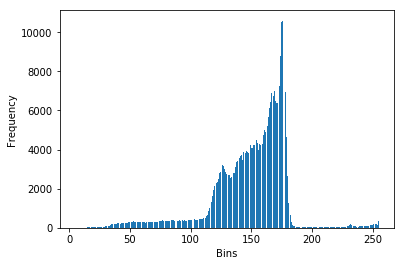

In [21]:
pdict = count_pixel(img)
pdict = count_pixel(img)
plist = np.asarray([[key,val] for key,val in pdict.items() if key != 0])
plist_t = plist.T
plt.bar(plist_t[0],plist_t[1],align='center') # A bar chart
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.show()

In [15]:
img = cv2.imread('../task3_img/hough.jpg',0)
edges = cv2.Canny(img,50,150,apertureSize = 3)
cv2.namedWindow('edges', cv2.WINDOW_NORMAL)
cv2.imshow('edges', edges)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [10]:
img = cv2.imread('../task3_img/hough.jpg',0)
res_img = inv_binary_img(img, 127) * 255
cv2.namedWindow('res_img', cv2.WINDOW_NORMAL)
cv2.imshow('res_img', res_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [12]:
lines[0]

array([[0., 0.]], dtype=float32)

In [11]:
img2 = cv2.imread('../task3_img/hough.jpg')
img = cv2.imread('../task3_img/hough.jpg',0)
img = cv2.medianBlur(img,5)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                            cv2.THRESH_BINARY,11,2)
#plt.imshow(th3, 'gray')

In [12]:
th3_inv = inv_binary_img(th3, 127)

In [15]:
lines = cv2.HoughLines(th3_inv,1,np.pi/180,200)
for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(img2,(x1,y1),(x2,y2),(0,0,255),2)

In [16]:
cv2.namedWindow('img2', cv2.WINDOW_NORMAL)
cv2.imshow('img2', img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Depreciated

In [4]:
# unused
def magnitude_edges(edge_x, edge_y):
    """
    Purpose: 
        Combine the vertical image and horizontal image.
    Input:
        edge_x: two dimension matrix
            the image filted by VERTICAL_SOBEL
        edge_y: two dimension matrix
            the image filted by HORIZONTAL_SOBEL
    Output:
        edge_magnitude: two dimension matrix
            the image combined by edge_x and edge_y
        
    """
    edge_magnitude = np.sqrt(edge_x ** 2 + edge_y ** 2)
    max_ = np.max(edge_magnitude)
    edge_magnitude /= max_
    return edge_magnitude